# Milestone 2: baseline models
___

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models, evaluate
from importlib import reload
reload(import_preprocess)
reload(baseline_models)
reload(evaluate)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int
from baseline_models import XGBoostClassifier, MajorityClassClassifier, RuleBasedClassifier, NaiveBayesClassifier, LogisticRegression, LSTM_Model, get_all_predictions

2024-12-14 22:11:58.717337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-14 22:11:58.717368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-14 22:11:58.718464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 22:11:58.724911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-14 22:11:59.346365: W tensorflow/compiler/tf2

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
X_val, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
X_test, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
X_balanced, y_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


In [3]:
# import_preprocess.convert_class_labels()
# y_train, y_dev, y_test = import_preprocess.y_train, import_preprocess.y_dev, import_preprocess.y_test

In [4]:
#X_train_dev, y_train_val = import_preprocess.concatenate_train_val()
#len(X_train_dev)
S_train[1]

'This is like the Metallica video where the poor mutilated bastard was saying "Please kill me" over and over again, only with emojis instead of Morse code.'

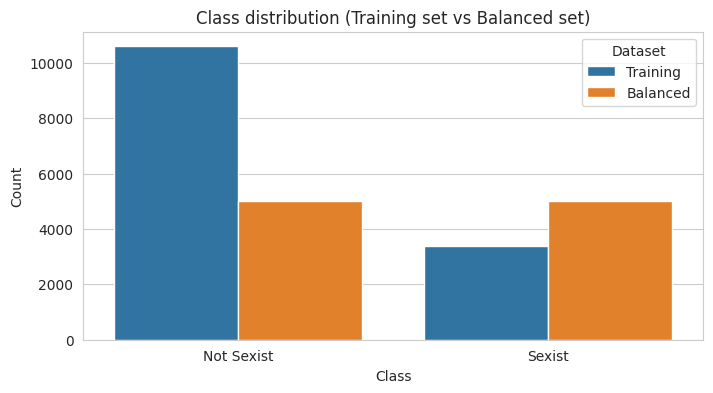

In [5]:
plot_data = pd.DataFrame({
    'Class': ['Not Sexist', 'Sexist'],
    'Training': [y_train.count('not sexist'), y_train.count('sexist')],
    'Balanced': [y_balanced.count('not sexist'), y_balanced.count('sexist')]
})
plot_data_melted = plot_data.melt(id_vars='Class', var_name='Dataset', value_name='Count')
plt.figure(figsize=(8, 4))
sns.barplot(x='Class', y='Count', hue='Dataset', data=plot_data_melted)
plt.title('Class distribution (Training set vs Balanced set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [6]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### a) Traditional (non-DL) baseline models

1. majority class classifier

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.7573
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



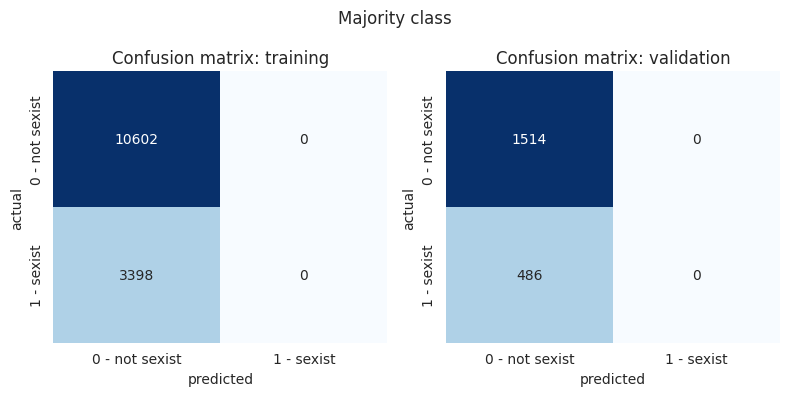

In [7]:
majority_class_classifier = MajorityClassClassifier()
majority_class_classifier.train(None, y_train, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="Majority class")
for res_x in res:
    results.loc[len(results)] = res_x

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.5000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



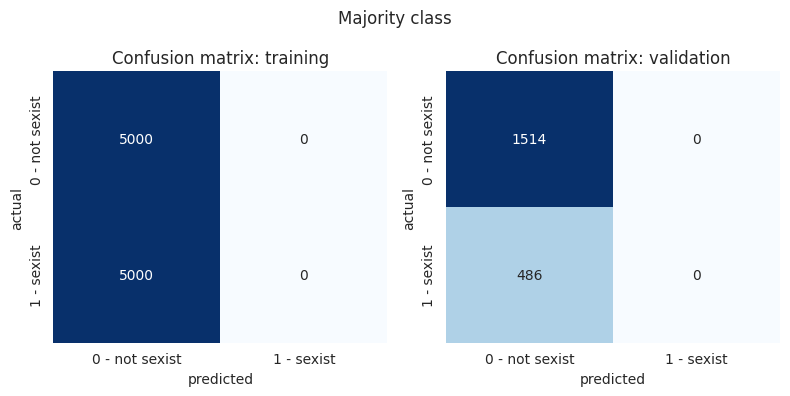

In [8]:
majority_class_classifier.train(None, y_balanced, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="Majority class")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

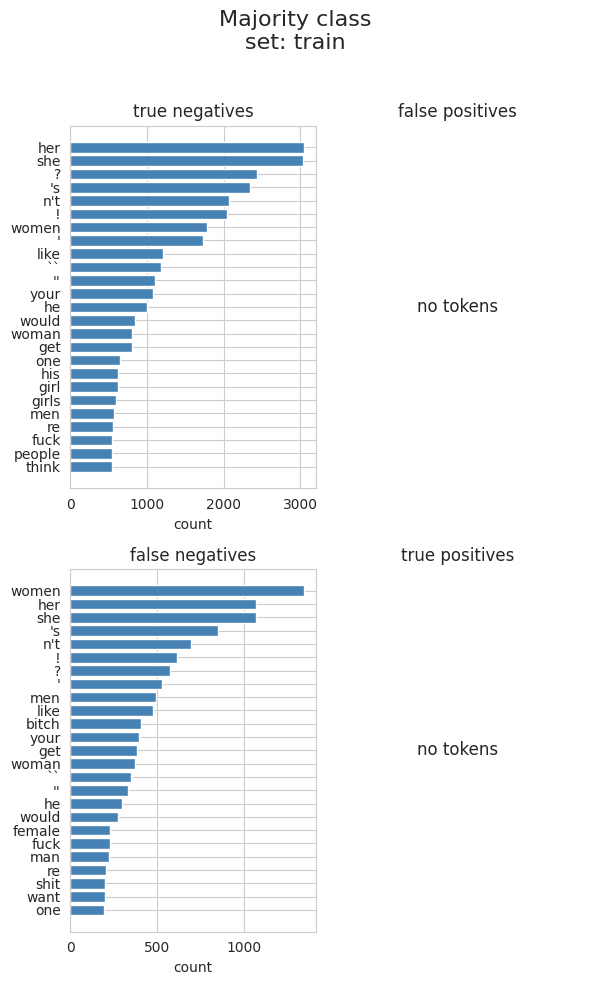

In [9]:
majority_class_classifier.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="Majority class", plot=True)

2. regex classifier (rule-based)

########################################

Metrics for training
accuracy: 0.7164
balanced accuracy: 0.5732
precision: 0.3890
recall: 0.2949

########################################

Metrics for validation
accuracy: 0.7075
balanced accuracy: 0.5630
precision: 0.3673
recall: 0.2819

########################################



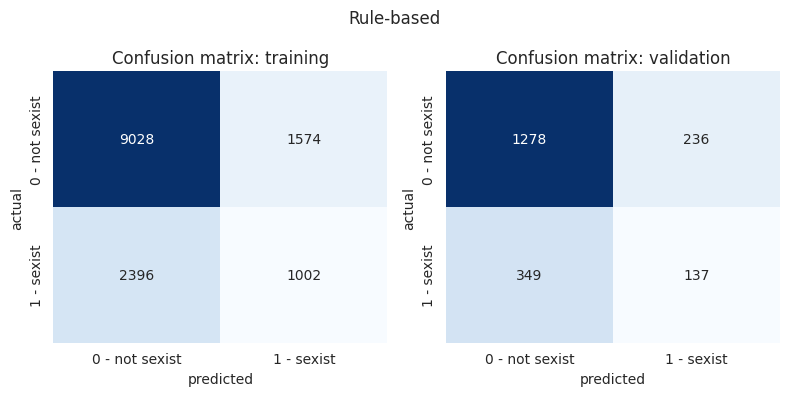

In [10]:
patterns = [
    r"\b(slut|bitch|fuck|fucking|sex)\b",
    r"\b(she has|she has to|she must|she shouldn't|women have to|women must|women shouldn't)\b",
    r"\b(hate|die)\b"
]

regex_classifier = RuleBasedClassifier(patterns)
res = regex_classifier.evaluate({"training": S_train, "validation": S_val}, [y_train, y_val], model_name="Rule-based")
for res_x in res:
    results.loc[len(results)] = res_x

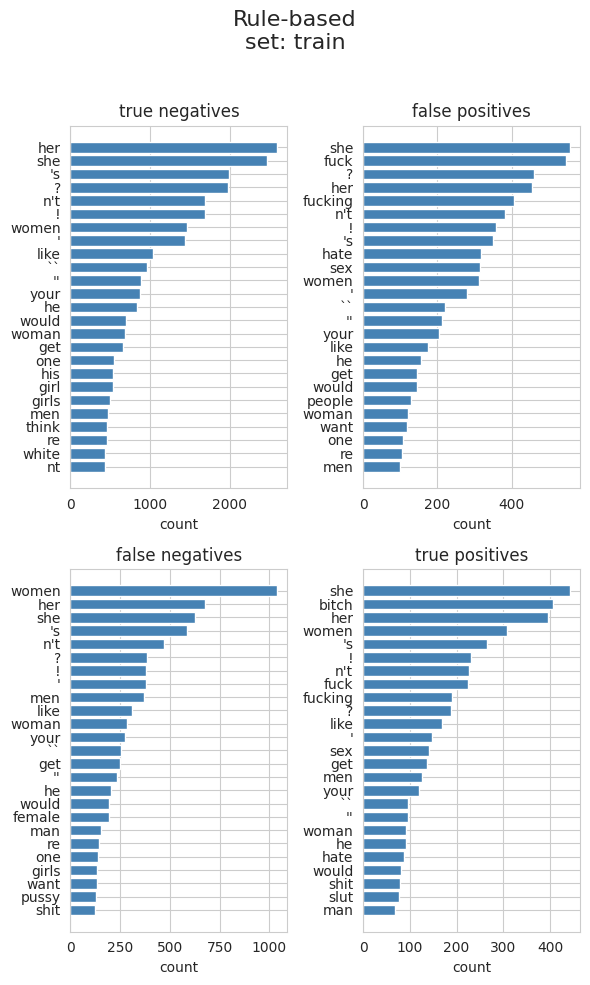

In [11]:
regex_classifier.qualitative_analysis_top_tokens(X_train, S_train, y_train, set_type="train", model_name="Rule-based", plot=True)

3. Naive Bayes (NB)

########################################

Metrics for training
accuracy: 0.8650
balanced accuracy: 0.7943
precision: 0.7551
recall: 0.6569

########################################

Metrics for validation
accuracy: 0.8155
balanced accuracy: 0.7140
precision: 0.6519
recall: 0.5165

########################################



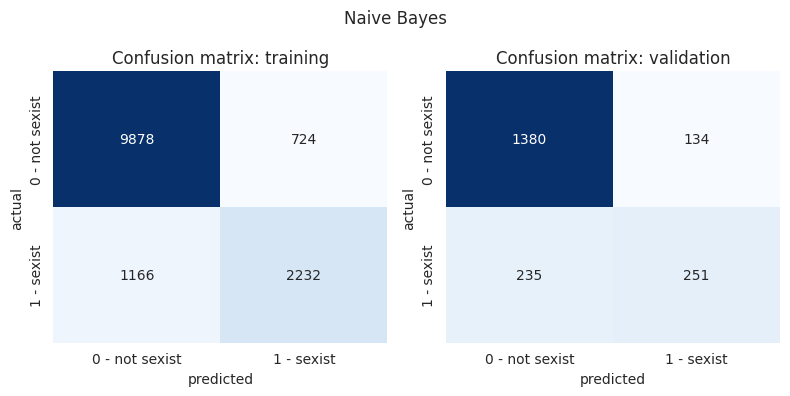

In [12]:
X_train_bow, X_val_bow, X_test_bow, X_train_val_bow, feature_names = import_preprocess.create_bow_representation()

naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x

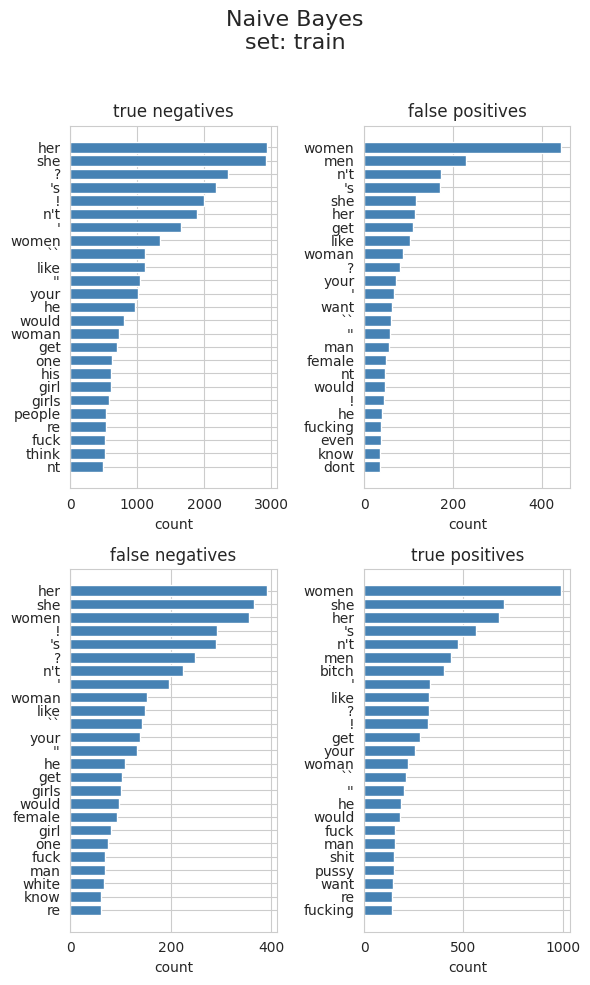

In [13]:
naive_bayes_classifier.qualitative_analysis_top_tokens(X_train, X_train_bow, y_train, set_type="train", model_name="Naive Bayes", plot=True)

In [14]:
top_tn_tokens, top_fp_tokens, top_fn_tokens, top_tp_tokens = \
    naive_bayes_classifier.qualitative_analysis_top_tokens(
        X_train, X_train_bow, y_train, set_type="train", 
        model_name="Naive Bayes", plot=False, top_n=50)

########################################

Metrics for training
accuracy: 0.8319
balanced accuracy: 0.8319
precision: 0.8234
recall: 0.8450

########################################

Metrics for validation
accuracy: 0.7125
balanced accuracy: 0.6997
precision: 0.4403
recall: 0.6749

########################################



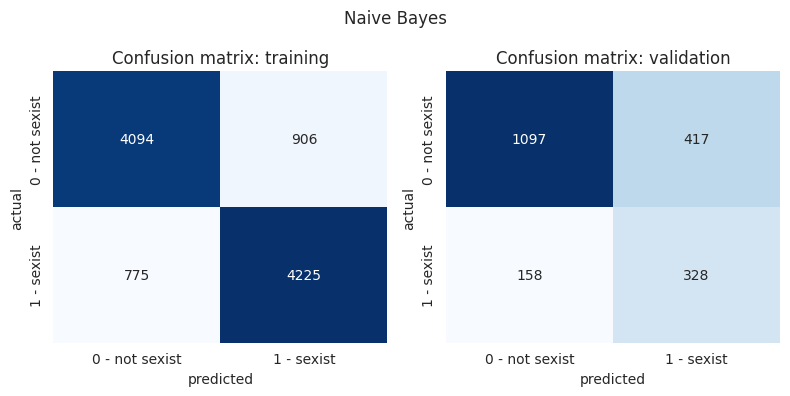

In [15]:
X_train_balanced_bow, X_val_balanced_bow, X_test_balanced_bow, X_train_val_balanced_bow, feature_names = import_preprocess.create_bow_representation(balanced=True)
naive_bayes_classifier.train(X_train_balanced_bow, y_balanced, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

4. Logisitic Regression

########################################

Metrics for training
accuracy: 0.8919
balanced accuracy: 0.8021
precision: 0.8955
recall: 0.6277

########################################

Metrics for validation
accuracy: 0.8310
balanced accuracy: 0.7081
precision: 0.7403
recall: 0.4691

########################################



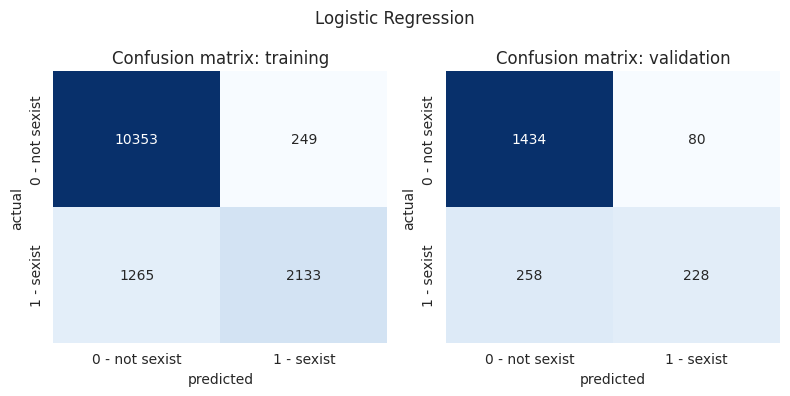

In [16]:
log_reg_classifier = LogisticRegression()
log_reg_classifier.train(X_train_bow, y_train, None, None)

res = log_reg_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Logistic Regression")
for res_x in res:
    results.loc[len(results)] = res_x

########################################

Metrics for training
accuracy: 0.9140
balanced accuracy: 0.9140
precision: 0.9242
recall: 0.9020

########################################

Metrics for validation
accuracy: 0.6365
balanced accuracy: 0.5699
precision: 0.3199
recall: 0.4403

########################################



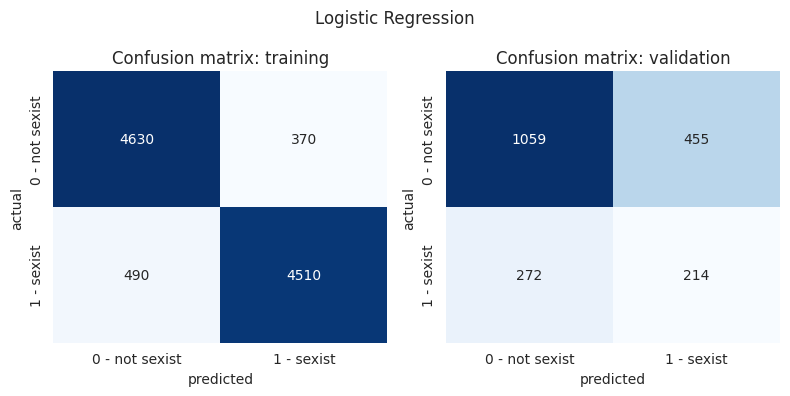

In [17]:
log_reg_classifier.train(X_train_balanced_bow, y_balanced, None, None)

res = log_reg_classifier.evaluate({"training": X_train_balanced_bow, "validation": X_val_bow}, [y_balanced, y_val], model_name="Logistic Regression")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (using BoW representation)

[0]	train-logloss:0.53009	eval-logloss:0.53454
[1]	train-logloss:0.51116	eval-logloss:0.51866
[2]	train-logloss:0.49586	eval-logloss:0.50590
[3]	train-logloss:0.48348	eval-logloss:0.49566
[4]	train-logloss:0.47308	eval-logloss:0.48727


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:12:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	train-logloss:0.46405	eval-logloss:0.48068
[6]	train-logloss:0.45658	eval-logloss:0.47452
[7]	train-logloss:0.44996	eval-logloss:0.47000
[8]	train-logloss:0.44414	eval-logloss:0.46612
[9]	train-logloss:0.43921	eval-logloss:0.46179
[10]	train-logloss:0.43483	eval-logloss:0.45844
[11]	train-logloss:0.43071	eval-logloss:0.45608
[12]	train-logloss:0.42720	eval-logloss:0.45407
[13]	train-logloss:0.42371	eval-logloss:0.45154
[14]	train-logloss:0.42068	eval-logloss:0.44925
[15]	train-logloss:0.41710	eval-logloss:0.44717
[16]	train-logloss:0.41453	eval-logloss:0.44600
[17]	train-logloss:0.41212	eval-logloss:0.44429
[18]	train-logloss:0.40972	eval-logloss:0.44285
[19]	train-logloss:0.40777	eval-logloss:0.44189
[20]	train-logloss:0.40607	eval-logloss:0.44081
[21]	train-logloss:0.40431	eval-logloss:0.43902
[22]	train-logloss:0.40212	eval-logloss:0.43790
[23]	train-logloss:0.40026	eval-logloss:0.43648
[24]	train-logloss:0.39888	eval-logloss:0.43567
[25]	train-logloss:0.39726	eval-logloss:0.434

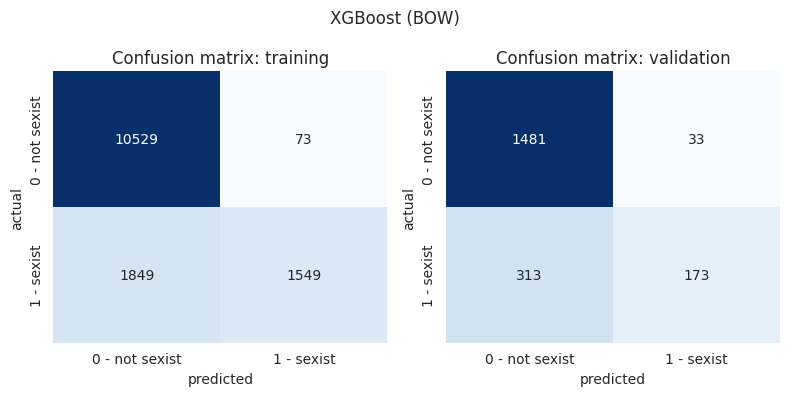

In [18]:
xg_boost_bow = XGBoostClassifier()
xg_boost_bow.train(X_train_bow, y_train, X_val_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66728	eval-logloss:0.67001
[1]	train-logloss:0.64626	eval-logloss:0.65134
[2]	train-logloss:0.62885	eval-logloss:0.63596
[3]	train-logloss:0.61402	eval-logloss:0.62216
[4]	train-logloss:0.60173	eval-logloss:0.61109
[5]	train-logloss:0.59105	eval-logloss:0.60143
[6]	train-logloss:0.58205	eval-logloss:0.59315


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:12:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	train-logloss:0.57394	eval-logloss:0.58550
[8]	train-logloss:0.56605	eval-logloss:0.57911
[9]	train-logloss:0.55936	eval-logloss:0.57344
[10]	train-logloss:0.55346	eval-logloss:0.56820
[11]	train-logloss:0.54824	eval-logloss:0.56338
[12]	train-logloss:0.54339	eval-logloss:0.55936
[13]	train-logloss:0.53874	eval-logloss:0.55509
[14]	train-logloss:0.53381	eval-logloss:0.55156
[15]	train-logloss:0.53002	eval-logloss:0.54836
[16]	train-logloss:0.52624	eval-logloss:0.54546
[17]	train-logloss:0.52284	eval-logloss:0.54268
[18]	train-logloss:0.51987	eval-logloss:0.54018
[19]	train-logloss:0.51702	eval-logloss:0.53770
[20]	train-logloss:0.51289	eval-logloss:0.53550
[21]	train-logloss:0.50995	eval-logloss:0.53295
[22]	train-logloss:0.50573	eval-logloss:0.53109
[23]	train-logloss:0.50368	eval-logloss:0.52915
[24]	train-logloss:0.50176	eval-logloss:0.52761
[25]	train-logloss:0.49955	eval-logloss:0.52617
[26]	train-logloss:0.49748	eval-logloss:0.52478
[27]	train-logloss:0.49450	eval-logloss:0.5

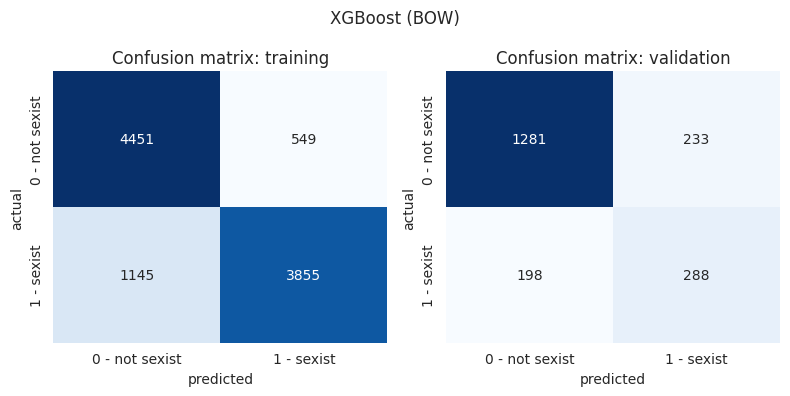

In [19]:
xg_boost_bow.train(X_train_balanced_bow, y_balanced, X_val_balanced_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (TF-IDF representation)

[0]	train-logloss:0.52958	eval-logloss:0.53394
[1]	train-logloss:0.51006	eval-logloss:0.51771
[2]	train-logloss:0.49477	eval-logloss:0.50527
[3]	train-logloss:0.48208	eval-logloss:0.49567


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:12:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	train-logloss:0.47150	eval-logloss:0.48764
[5]	train-logloss:0.46256	eval-logloss:0.48115
[6]	train-logloss:0.45455	eval-logloss:0.47554
[7]	train-logloss:0.44794	eval-logloss:0.47048
[8]	train-logloss:0.44167	eval-logloss:0.46661
[9]	train-logloss:0.43624	eval-logloss:0.46296
[10]	train-logloss:0.43158	eval-logloss:0.45925
[11]	train-logloss:0.42734	eval-logloss:0.45712
[12]	train-logloss:0.42351	eval-logloss:0.45468
[13]	train-logloss:0.42008	eval-logloss:0.45318
[14]	train-logloss:0.41695	eval-logloss:0.45141
[15]	train-logloss:0.41380	eval-logloss:0.44947
[16]	train-logloss:0.41114	eval-logloss:0.44779
[17]	train-logloss:0.40869	eval-logloss:0.44596
[18]	train-logloss:0.40639	eval-logloss:0.44461
[19]	train-logloss:0.40376	eval-logloss:0.44379
[20]	train-logloss:0.40192	eval-logloss:0.44245
[21]	train-logloss:0.40015	eval-logloss:0.44112
[22]	train-logloss:0.39772	eval-logloss:0.44045
[23]	train-logloss:0.39588	eval-logloss:0.43968
[24]	train-logloss:0.39355	eval-logloss:0.4381

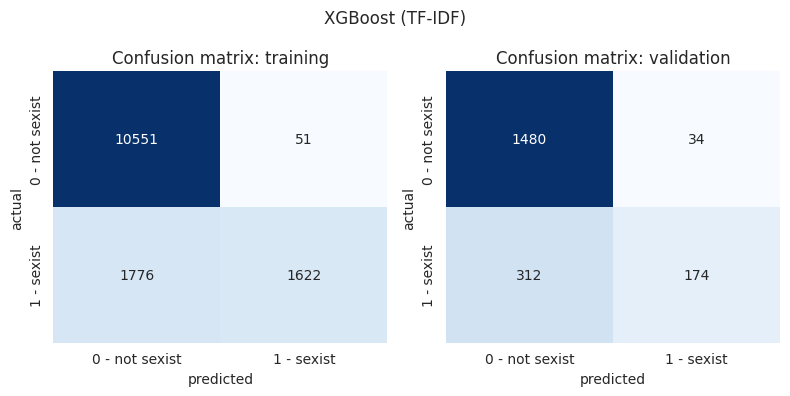

In [20]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, X_train_val_tfidf, feature_names = import_preprocess.create_tfidf_representation()

xg_boost_tfidf = XGBoostClassifier()
xg_boost_tfidf.train(X_train_tfidf, y_train, X_val_tfidf, y_val)

res = xg_boost_tfidf.evaluate({"training": X_train_tfidf, "validation": X_val_tfidf}, [y_train, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66699	eval-logloss:0.66985
[1]	train-logloss:0.64565	eval-logloss:0.65082
[2]	train-logloss:0.62736	eval-logloss:0.63513
[3]	train-logloss:0.61197	eval-logloss:0.62194
[4]	train-logloss:0.59910	eval-logloss:0.61044


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:12:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	train-logloss:0.58813	eval-logloss:0.60073
[6]	train-logloss:0.57854	eval-logloss:0.59231
[7]	train-logloss:0.56954	eval-logloss:0.58443
[8]	train-logloss:0.56140	eval-logloss:0.57752
[9]	train-logloss:0.55428	eval-logloss:0.57107
[10]	train-logloss:0.54818	eval-logloss:0.56566
[11]	train-logloss:0.54224	eval-logloss:0.56080
[12]	train-logloss:0.53645	eval-logloss:0.55613
[13]	train-logloss:0.53159	eval-logloss:0.55202
[14]	train-logloss:0.52723	eval-logloss:0.54882
[15]	train-logloss:0.52307	eval-logloss:0.54617
[16]	train-logloss:0.51832	eval-logloss:0.54298
[17]	train-logloss:0.51454	eval-logloss:0.53991
[18]	train-logloss:0.51014	eval-logloss:0.53753
[19]	train-logloss:0.50684	eval-logloss:0.53460
[20]	train-logloss:0.50287	eval-logloss:0.53297
[21]	train-logloss:0.50056	eval-logloss:0.53047
[22]	train-logloss:0.49727	eval-logloss:0.52854
[23]	train-logloss:0.49479	eval-logloss:0.52667
[24]	train-logloss:0.49183	eval-logloss:0.52504
[25]	train-logloss:0.48964	eval-logloss:0.523

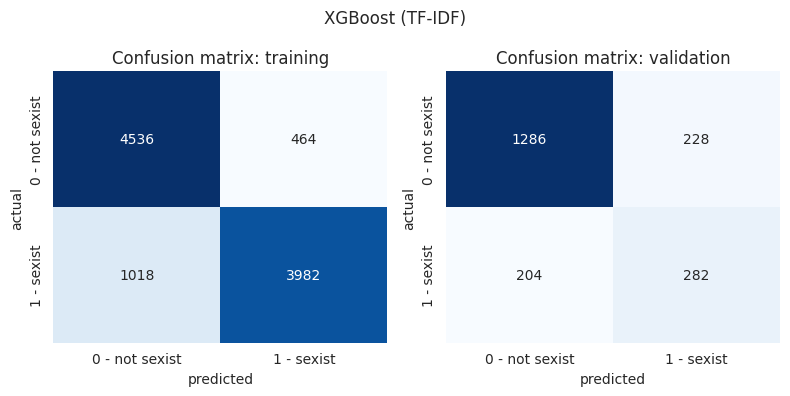

In [21]:
X_train_balanced_tfidf, X_val_balanced_tfidf, X_test_balanced_tfidf, X_train_val_balanced_tfidf, feature_names = import_preprocess.create_tfidf_representation(balanced=True)

xg_boost_tfidf.train(X_train_balanced_tfidf, y_balanced, X_val_balanced_tfidf, y_val)

res = xg_boost_tfidf.evaluate({"training": X_train_balanced_tfidf, "validation": X_val_balanced_tfidf}, [y_balanced, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

#### b) DL baseline models

1. LSTM

Epoch 1/10


2024-12-14 22:12:20.151431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-14 22:12:20.168995: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


438/438 [==============================] - 7s 13ms/step - loss: 0.5573 - accuracy: 0.7561 - val_loss: 0.5529 - val_accuracy: 0.7570
Epoch 2/10
438/438 [==============================] - 5s 12ms/step - loss: 0.5109 - accuracy: 0.7758 - val_loss: 0.4691 - val_accuracy: 0.8005
Epoch 3/10
438/438 [==============================] - 5s 12ms/step - loss: 0.3981 - accuracy: 0.8371 - val_loss: 0.4412 - val_accuracy: 0.8200
Epoch 4/10
438/438 [==============================] - 5s 12ms/step - loss: 0.3367 - accuracy: 0.8664 - val_loss: 0.4381 - val_accuracy: 0.8160
Epoch 5/10
438/438 [==============================] - 5s 12ms/step - loss: 0.2991 - accuracy: 0.8863 - val_loss: 0.4250 - val_accuracy: 0.8210
Epoch 6/10
438/438 [==============================] - 5s 12ms/step - loss: 0.2643 - accuracy: 0.9059 - val_loss: 0.4422 - val_accuracy: 0.8240
Epoch 7/10
438/438 [==============================] - 5s 12ms/step - loss: 0.2373 - accuracy: 0.9174 - val_loss: 0.4312 - val_accuracy: 0.8220
Epoch 8/10

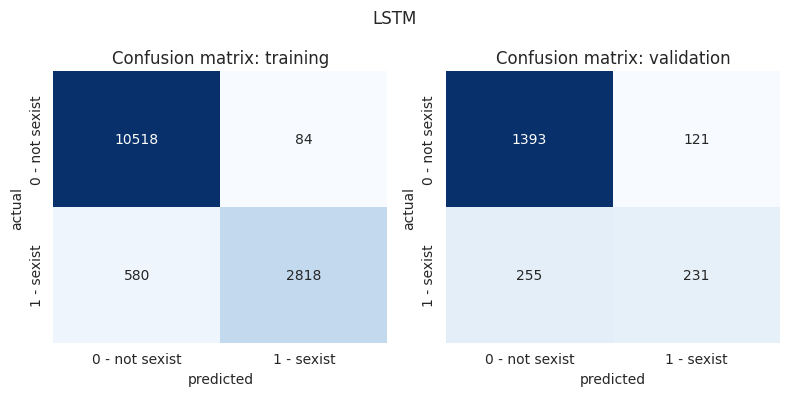

In [22]:
y_train = convert_labels_to_int(y_train)
y_balanced = convert_labels_to_int(y_balanced)
y_val = convert_labels_to_int(y_val)

rnn = LSTM_Model()
rnn.train(X_train, y_train, X_val, y_val)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x

Epoch 1/10
313/313 [==============================] - 5s 13ms/step - loss: 0.6936 - accuracy: 0.4933 - val_loss: 0.7092 - val_accuracy: 0.2430
Epoch 2/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6935 - accuracy: 0.4944 - val_loss: 0.6869 - val_accuracy: 0.7570
Epoch 3/10
313/313 [==============================] - 4s 11ms/step - loss: 0.6934 - accuracy: 0.4966 - val_loss: 0.6846 - val_accuracy: 0.7570
Epoch 4/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6934 - accuracy: 0.4926 - val_loss: 0.6918 - val_accuracy: 0.7565
Epoch 5/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6945 - val_accuracy: 0.2430
Epoch 6/10
313/313 [==============================] - 4s 11ms/step - loss: 0.6933 - accuracy: 0.4983 - val_loss: 0.6961 - val_accuracy: 0.2430
Epoch 7/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6839 - val_accuracy: 0.7570

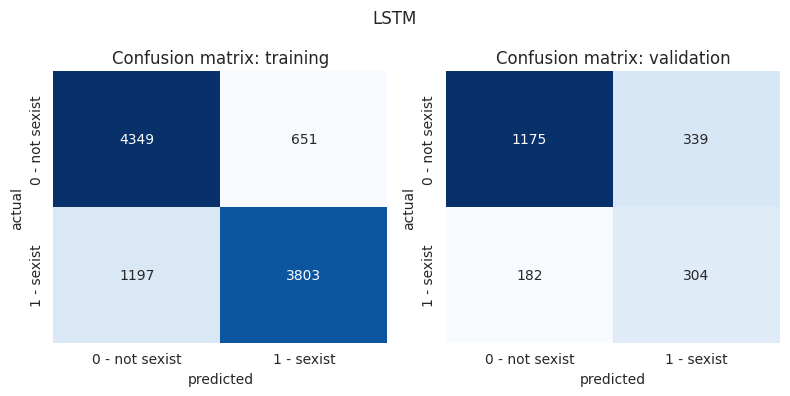

In [23]:
# y_train = convert_labels_to_int(y_train)
# y_balanced = convert_labels_to_int(y_balanced)
# y_val = convert_labels_to_int(y_val)
rnn.train(X_balanced, y_balanced, X_val, y_val)
res = rnn.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

438/438 [==============================] - 1s 3ms/step


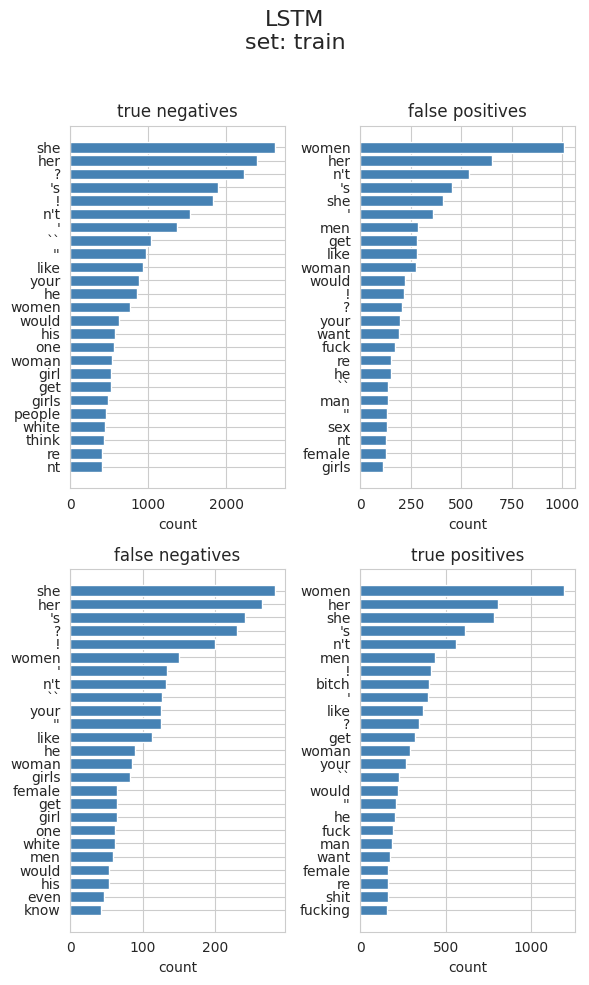

In [24]:
rnn.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="LSTM", plot=True)

## Results

In [25]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.757286,0.500000,0.000000,0.000000
1,Majority class,validation,0.757000,0.500000,0.000000,0.000000
2,Rule-based,training,0.716429,0.573208,0.388975,0.294879
3,Rule-based,validation,0.707500,0.563007,0.367292,0.281893
4,Naive Bayes,training,0.865000,0.794284,0.755074,0.656857
5,Naive Bayes,validation,0.815500,0.713977,0.651948,0.516461
6,Logistic Regression,training,0.891857,0.802118,0.895466,0.627722
7,Logistic Regression,validation,0.831000,0.708148,0.740260,0.469136
8,XGBoost (BOW),training,0.862714,0.724485,0.954994,0.455856
9,XGBoost (BOW),validation,0.827000,0.667085,0.839806,0.355967


In [26]:
balanced_results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.5000,0.500000,0.000000,0.000000
1,Majority class,validation,0.7570,0.500000,0.000000,0.000000
2,Naive Bayes,training,0.8319,0.831900,0.823426,0.845000
3,Naive Bayes,validation,0.7125,0.699734,0.440268,0.674897
4,Logistic Regression,training,0.9140,0.914000,0.924180,0.902000
5,Logistic Regression,validation,0.6365,0.569900,0.319880,0.440329
6,XGBoost (BOW),training,0.8306,0.830600,0.875341,0.771000
7,XGBoost (BOW),validation,0.7845,0.719348,0.552783,0.592593
8,XGBoost (TF-IDF),training,0.8518,0.851800,0.895637,0.796400
9,XGBoost (TF-IDF),validation,0.7840,0.714826,0.552941,0.580247


In [27]:
models_dict = {
    "Majority Class": majority_class_classifier,
    "Naive Bayes": naive_bayes_classifier,
    "Logistic Regression": log_reg_classifier,
    "XGBoost (BOW)": xg_boost_bow,
    "LSTM": rnn
}

predictions = get_all_predictions(models_dict, X_val[1], X_val_bow[1], y_val[1])

1/1 [==============================] - 0s 18ms/step


In [28]:
predictions

{'true': 'not sexist',
 'Majority Class': ['not sexist'],
 'Naive Bayes': array(['not sexist'], dtype='<U10'),
 'Logistic Regression': array(['not sexist'], dtype='<U10'),
 'XGBoost (BOW)': ['not sexist'],
 'LSTM': 'not sexist'}

In [29]:
y_pred = rnn.predict(X_val)
y_pred = convert_labels_to_string(y_pred)
y_val = y_val if isinstance(y_val[0], str) else convert_labels_to_string(y_val)

false_negative_indices = [i for i in range(len(X_val)) if y_val[i] == 'sexist' and y_pred[i] == 'not sexist']
false_negative_sentences = [S_val[i] for i in false_negative_indices]
false_negative_sentences

63/63 [==============================] - 0s 2ms/step


["aim for the head so she dosn't come back",
 'until she\'s been around me long enough through real life situations where I can actually see who she really is Like observing her rage when the wifi connection is set to "shit-tier" on the router on purpose. ]=)',
 'Sheâ\x80\x99s unstable, youâ\x80\x99ll never know when she might dump you or cuck you for the ugliest thug in the nearest gang.',
 'A quarter of a $million$ for this slag to buy enough sexy stuff to get laid? She should have just brought her own paper bag! [URL]',
 'A woman needs a man like a fish needs a bicycle!Â¹ ----- Â¹assuming fish spend half their life dreaming about finding the perfect bicycle',
 "I've only known 2 or 3 men in my entire life that micro managed their wives, girlfriends. It's exhausting and not worth it and most men are not that tiny, tiny minded, spiteful, hate filled and petty like a woman's mind is.",
 'Just block her, the dating pool is ruled by men if you enforce your standards',
 "Yeah it's funny h

# Report on Misclassification Analysis of RNN Model

In [32]:
import random
random.seed(1234)
# Predict on the test set
y_pred_test = rnn.predict(X_test)

# Convert predictions and true labels to string format
y_pred_test = convert_labels_to_string(y_pred_test)
y_test = y_test if isinstance(y_test[0], str) else convert_labels_to_string(y_test)

# Identify indices for each confusion matrix quadrant
tp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'sexist']  # True Positives
tn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'not sexist']  # True Negatives
fp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'sexist']  # False Positives
fn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'not sexist']  # False Negatives

# Randomly sample up to 25 sentences from each quadrant
sampled_tp_test = random.sample(tp_indices_test, min(25, len(tp_indices_test)))
sampled_tn_test = random.sample(tn_indices_test, min(25, len(tn_indices_test)))
sampled_fp_test = random.sample(fp_indices_test, min(25, len(fp_indices_test)))
sampled_fn_test = random.sample(fn_indices_test, min(25, len(fn_indices_test)))

# Extract sentences for sampled indices
sampled_sentences_tp_test = [S_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test = [S_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test = [S_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test = [S_test[i] for i in sampled_fn_test]

# Extract multi labels for sampled indices
sampled_sentences_tp_test_multi_label = [y_test_multi[i] for i in sampled_tp_test]
sampled_sentences_tn_test_multi_label = [y_test_multi[i] for i in sampled_tn_test]
sampled_sentences_fp_test_multi_label = [y_test_multi[i] for i in sampled_fp_test]
sampled_sentences_fn_test_multi_label = [y_test_multi[i] for i in sampled_fn_test]

# Extract labels for sampled indices
sampled_sentences_tp_test_label = [y_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test_label = [y_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test_label = [y_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test_label = [y_test[i] for i in sampled_fn_test]

tp_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_tp_test_multi_label, sampled_sentences_tp_test_label)])
tn_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_tn_test_multi_label, sampled_sentences_tn_test_label)])
fp_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_fp_test_multi_label, sampled_sentences_fp_test_label)])
fn_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_fn_test_multi_label, sampled_sentences_fn_test_label)])

# Print the sampled sentences for analysis
print(f"Sampled True Positives (TP), {tp_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_tp_test, sampled_sentences_tp_test_label, sampled_sentences_tp_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled True Negatives (TN), {tn_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_tn_test, sampled_sentences_tn_test_label, sampled_sentences_tn_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled False Positives (FP), {fp_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_fp_test, sampled_sentences_fp_test_label, sampled_sentences_fp_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled False Negatives (FN), {fn_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_fn_test, sampled_sentences_fn_test_label, sampled_sentences_fn_test_multi_label):
    print(s_y, s_y_multi, sentence)


125/125 [==============================] - 0s 3ms/step
Sampled True Positives (TP), 92 samples in agreement:
sexist ['not sexist', 'sexist', 'sexist'] Those who are trying to make it big in business. Having attractive female workers. These situations can happen. But in the end. It will all come back to you. Either she records you or blackmails your sorry ass. There's no happy endings.
sexist ['sexist', 'sexist', 'sexist'] All females must take collective responsibility for false rape accusations!
sexist ['not sexist', 'sexist', 'not sexist'] Real men aren't violent Real women are If I said that on r/feminism I would be banned instantly and if I said it in real life I would be labeled a sexist. But since it's a man it's OK because men are violent aren't they?
sexist ['sexist', 'sexist', 'sexist'] I don't know. I think girls are smart now days and know guys don't have as many options as girls.
sexist ['sexist', 'sexist', 'sexist'] Every fucking time. After the trial expires it's always "

## Overview
We are going into an in depth analysis of the RNN model's misclassifications on the test dataset for a sexism detection task. It categorizes the sentences into four confusion matrix quadrants:
- **True Positives (TP):** Correctly classified as sexist.
- **True Negatives (TN):** Correctly classified as not sexist.
- **False Positives (FP):** Incorrectly classified as sexist.
- **False Negatives (FN):** Incorrectly classified as not sexist.

With this analysis we identify patterns in the misclassified samples and suggests improvements to enhance the model's performance.

---

## True Positives (TP)

### **Characteristics:**
- These sentences contain overt sexism, including:
  - Explicit slurs (e.g., "cunt," "bitch," "whore").
  - Objectifying women (e.g., "like a walking dildo").
  - Hostility towards women in power or feminists (e.g., "Fuck this stupid woman").
  - Stereotypes of traditional gender roles (e.g., "Don’t let women vote").

### **Patterns:**
- Use of explicit misogynistic slurs.
- Contextual misogyny targeting gender roles or political affiliations.
- Common references to male-dominant ideologies like MGTOW.

### **Examples:**
- "The sad reality is without sex, men don’t need or want women. But women desire and crave male attention, that’s why they are constantly invading and taking over male spaces."
- "That ho is nothing but a cat's full little box throw her to the dump!"
- "Wow, cheating is so easy and natural for women, that even women in their 80s can do it."

---

## True Negatives (TN)

### **Characteristics:**
- These sentences do not contain sexism and were correctly identified as not sexist.
- They include:
  - Neutral personal reflections (e.g., "My life is filled with things I love: video games, soccer, backpacking trips").
  - Discussions about unrelated topics (e.g., "Quality? I don’t know about you but Cap’s gay ass little arm shields ruined it for me").
  - Sarcastic or humorous comments unrelated to sexism.

### **Patterns:**
- Neutral language and context unrelated to sexism.
- Sarcasm or humor that lacks hostile undertones.
- Discussions focusing on non gender related issues.

### **Examples:**
- "LOL, a Canadian guy legally changed his gender to female so that he would save $1000 a year on car insurance."
- "Normal and normal, girls just don't find me attractive."
- "She stopped responding because there are probably 17 other guys talking to her at the same moment."

---

## False Positives (FP)

### **Characteristics:**
- Sentences incorrectly classified as sexist, possibly due to:
  - The presence of controversial or vulgar language.
  - Discussions of gender dynamics in neutral or balanced ways.
  - General references to feminists, MGTOW, or gendered terms (e.g., "Trouble with MGTOW is you take isolated incidents and judge all females like this").

### **Patterns:**
- Sentences discussing gender-related topics neutrally.
- Vulgar language unrelated to sexism (e.g., "Check the constitution, mother fucker").
- Balanced critique or reflections on societal issues involving gender.

### **Examples:**
- "You can’t get women because you have a shit personality. Maybe you are just creepy and it turns women away."
- "Women should be the first test group. No. They don't think that women should be the 'first test group.'"
- "Having a low sex drive to the point of being practically asexual is such a blessing... women have literally no effect or control over me."

### **Potential Causes:**
- Over-sensitivity to keywords like "women," "feminists," or "MGTOW."
- Lack of contextual understanding in distinguishing neutral discussions from sexism.

---

## False Negatives (FN)

### **Characteristics:**
- Sentences that contain sexism but were misclassified as not sexist.
- Often include:
  - Subtle or euphemistic sexism (e.g., "Women seemingly have endless amounts of time to waste").
  - Stereotypical gender roles (e.g., "Women talk for the sake of talking").
  - Sarcasm or coded language (e.g., "Chad is also catching regret rape claims later").

### **Patterns:**
- Subtle misogyny masked by indirect or sarcastic language.
- Stereotypical comments that lack explicit slurs but imply sexism.
- Euphemistic or metaphorical references to sexism.

### **Examples:**
- "This shows that there ain’t a limit to stupidity for females."
- "The boys should be killed. OK, now that we have that out of the way, why is a girl meeting two boys in a ditch to buy a knife?"

### **Potential Causes:**
- Lack of nuanced understanding of indirect sexism.
- Failure to detect sarcasm or rhetorical devices.

---